In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Baixando e explorando o conjunto de dados

Este tutorial usa um conjunto de dados de cerca de 3.700 fotos de flores. O conjunto de dados contém 5 subdiretórios, um por classe:

```
flower_photo/ flor_foto 
  daisy/ margarida
  dandelion/ dente de leão
  roses/ rosa
  sunflowers/ girasol
  tulips/ túlipa
  
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


Após o download, agora você deve ter uma cópia do conjunto de dados disponível. Existem 3.670 imagens no total:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Algumas rosas:

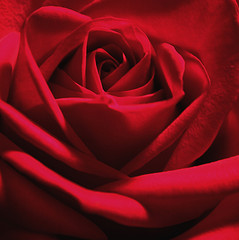

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

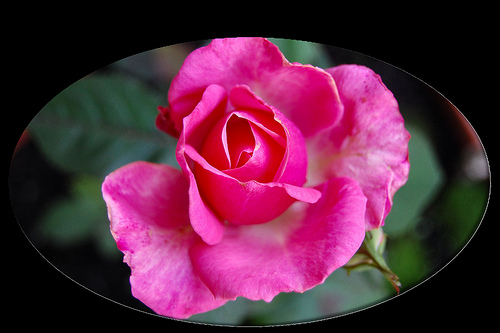

In [5]:
PIL.Image.open(str(roses[1]))

Algumas tulipas:

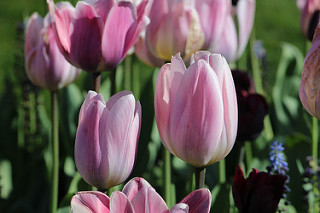

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

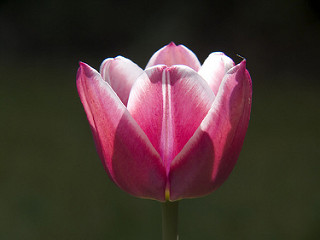

In [7]:
PIL.Image.open(str(tulips[1]))

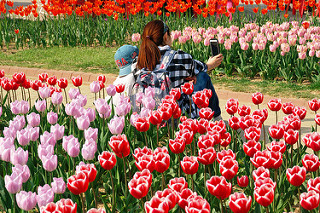

In [8]:
PIL.Image.open(str(tulips[5]))

# Load using keras.preprocessing

Vamos carregar essas imagens do disco usando o útil utilitário image_dataset_from_directory. Isso o levará de um diretório de imagens no disco para um tf.data.Dataset em apenas algumas linhas de código.

## Criando o Dataset

Definindo alguns parâmetros para o carregador:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

 Usando 80% das imagens para treinamento e 20% para validação.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Você pode encontrar os nomes das classes no atributo class_names nesses conjuntos de dados. Eles correspondem aos nomes dos diretórios em ordem alfabética.

In [12]:
class_names = train_ds.class_names

print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualizando os Dados

Aqui estão as primeiras 9 imagens do conjunto de dados de treinamento.

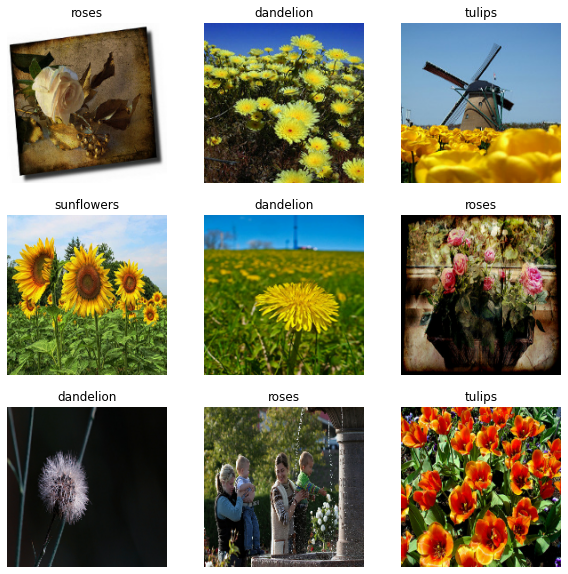

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Você treinará um modelo usando esses conjuntos de dados, passando-os para model.fit em um momento.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


O `image_batch` é um tensor da forma` (32, 180, 180, 3) `. Este é um lote de 32 imagens de formato `180x180x3` (a última dimensão refere-se aos canais de cores RGB). O `label_batch` é um tensor da forma` (32,) `, estes são rótulos correspondentes às 32 imagens.

Você pode chamar `.numpy ()` nos tensores `image_batch` e` labels_batch` para convertê-los em um `numpy.ndarray`.

## Configure o conjunto de dados para desempenho

---



Vamos nos certificar de usar a pré-busca em buffer para que você possa gerar dados do disco sem que o I / O se torne um bloqueio. Esses são dois métodos importantes que você deve usar ao carregar dados.

`Dataset.cache ()` mantém as imagens na memória após serem carregadas do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do seu modelo. Se o seu conjunto de dados for muito grande para caber na memória, você também pode usar este método para criar um cache em disco de alto desempenho.

`Dataset.prefetch ()` sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Padronizando os dados

Os valores do canal RGB estão na faixa de `[0, 255]`. Isso não é ideal para uma rede neural; em geral, você deve tentar diminuir os valores de entrada. Aqui, você padronizará os valores para estar na faixa de `[0, 1]` usando uma camada de reescalonamento.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9997713


# Criando o modelo

O modelo consiste em três blocos de convolução com uma camada máxima de pool em cada um deles. Há uma camada totalmente conectada com 128 unidades em cima dela que é ativada por uma função de ativação `relu`. Este modelo não foi ajustado para alta precisão. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilando o modelo



In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Resumo do modelo

Visualize todas as camadas da rede usando o método `summary` do modelo:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Treinando o Modelo

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 35s 35ms/step - loss: 1.4094 - accuracy: 0.3822 - val_loss: 1.1496 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0573 - accuracy: 0.5685 - val_loss: 1.0359 - val_accuracy: 0.5749
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8872 - accuracy: 0.6577 - val_loss: 0.9195 - val_accuracy: 0.6335
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6814 - accuracy: 0.7425 - val_loss: 0.9156 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4772 - accuracy: 0.8311 - val_loss: 0.9619 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2809 - accuracy: 0.9057 - val_loss: 1.1475 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1618 - accuracy: 0.9527 - val_loss: 1.3397 - val_accuracy: 0.6580
Epoch 8/10
9

## Visualizando os resultados do treino

Criando gráficos de perda e precisão nos conjuntos de treinamento e validação.

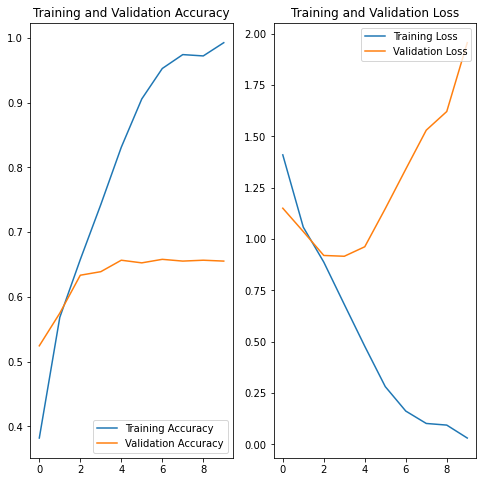

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como você pode ver nos gráficos, a precisão do treinamento e a precisão da validação estão erradas por uma grande margem e o modelo atingiu apenas cerca de 60% de precisão no conjunto de validação.

Vamos ver o que deu errado e tentar aumentar o desempenho geral do modelo.

## Overfitting

Nos gráficos acima, a precisão do treinamento está aumentando linearmente com o tempo, enquanto a precisão da validação para em torno de 60% no processo de treinamento. Além disso, a diferença na precisão entre a precisão do treinamento e da validação é perceptível - um sinal de [overfitting] (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Quando há um pequeno número de exemplos de treinamento, o modelo às vezes aprende com ruídos ou detalhes indesejados de exemplos de treinamento - a ponto de impactar negativamente o desempenho do modelo em novos exemplos. Este fenômeno é conhecido como overfitting. Isso significa que o modelo terá dificuldade em generalizar em um novo conjunto de dados.

Existem várias maneiras de combater o sobreajuste no processo de treinamento. Neste tutorial, você usará * aumento de dados * e adicionará * Dropout * ao seu modelo.

## Data augmentation

O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento. [Aumento de dados] (https://www.tensorflow.org/tutorials/images/data_augmentation) adota a abordagem de gerar dados de treinamento adicionais a partir de seus exemplos existentes, aumentando-os usando transformações aleatórias que produzem imagens de aparência confiável. Isso ajuda a expor o modelo a mais aspectos dos dados e generalizar melhor.

Você implementará o aumento de dados usando as camadas de `tf.keras.layers.experimental.preprocessing`. Eles podem ser incluídos dentro de seu modelo como outras camadas e executados na GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


Vamos visualizar a aparência de alguns exemplos aumentados aplicando o aumento de dados à mesma imagem várias vezes:

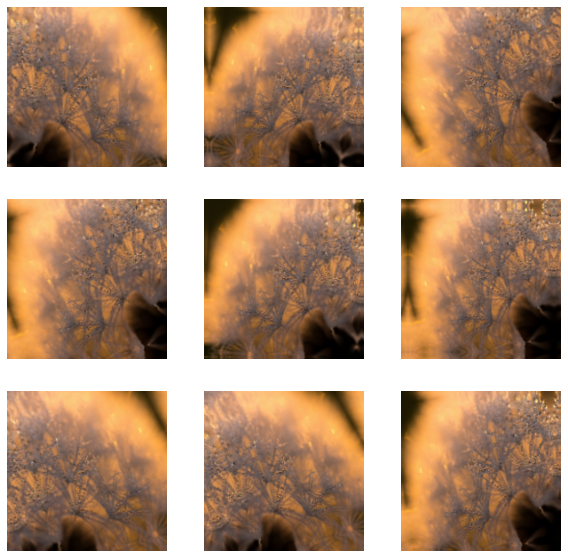

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Usando o aumento de dados para treinar um modelo em um momento.

Outra técnica para reduzir o overfitting é introduzir o Dropout na rede, uma forma de regularização.

Quando você aplica Dropout a uma camada, ela exclui aleatoriamente (definindo a ativação para zero) um número de unidades de saída da camada durante o processo de treinamento. O dropout leva um número fracionário como seu valor de entrada, na forma como 0,1, 0,2, 0,4, etc. Isso significa retirar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

Vamos criar uma nova rede neural usando layers.Dropout e, em seguida, treiná-la usando imagens aumentadas.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilando e treinando o modelo

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 26ms/step - loss: 1.3430 - accuracy: 0.3975 - val_loss: 1.1889 - val_accuracy: 0.5150
Epoch 2/15
92/92 [==============================] - 2s 22ms/step - loss: 1.0495 - accuracy: 0.5794 - val_loss: 1.0330 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 2s 22ms/step - loss: 0.9677 - accuracy: 0.6161 - val_loss: 1.1246 - val_accuracy: 0.5913
Epoch 4/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8891 - accuracy: 0.6543 - val_loss: 0.8696 - val_accuracy: 0.6444
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8366 - accuracy: 0.6778 - val_loss: 1.1163 - val_accuracy: 0.6063
Epoch 6/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7929 - accuracy: 0.6918 - val_loss: 0.7968 - val_accuracy: 0.6866
Epoch 7/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7411 - accuracy: 0.7187 - val_loss: 0.7464 - val_accuracy: 0.7153
Epoch 8/15
92

## Visualizando os resultados


Depois de aplicar o aumento de dados e Dropout, há menos overfitting do que antes, e a precisão do treinamento e da validação estão mais alinhadas. 

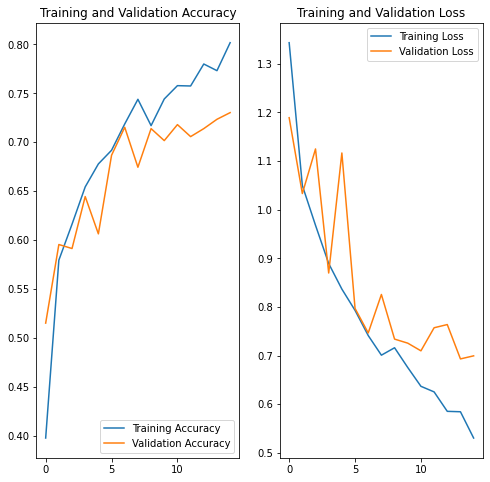

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prevendo novos dados

Finalmente, vamos usar nosso modelo para classificar uma imagem que não foi incluída nos conjuntos de treinamento ou validação.

As camadas de aumento de dados e exclusão são inativas no momento da inferência.

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to  'SUNFLOWERS'  with a 99.98 percent confidence.


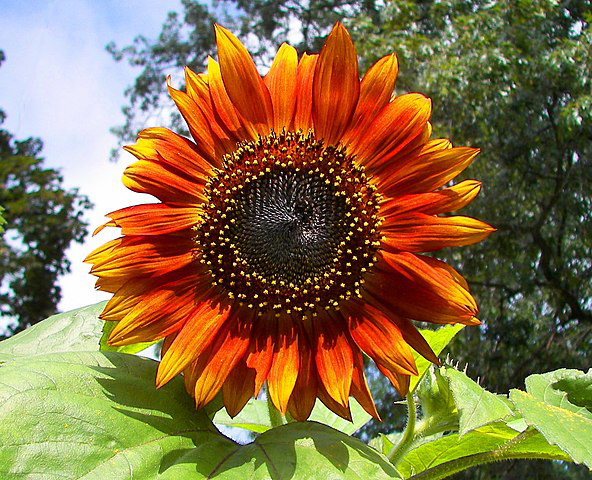

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to \033[1m '{}' \033[0m with a {:.2f} percent confidence.".format(class_names[np.argmax(score)].upper(), 100 * np.max(score)))
PIL.Image.open(str(sunflower_path))